# Seldonian Model example usage notebook
This notebook shows the usage of the `seldonian` library to train a `LogisticRegression` classifier on the [UCI Adult Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult)

https://github.com/hannanabdul55/seldonian-fairness

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    import seldonian
except:
    !pip install seldonian
import torch
import numpy as np
try:
    import shap
except:
    !pip install shap

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from seldonian.seldonian import *
from seldonian.objectives import ghat_tpr_diff, ghat_recall_rate, recall_rate, tpr_rate
from seldonian.bounds import ttest_bounds, hoeffdings_bounds

# Dataset
We use the `shap` library to import the preprocessed version of the Adult data. 

In [ ]:
from sklearn import preprocessing
import pandas as pd

df_assessments_agg_filtered = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fair AI/algebra_nation/aggregated_assessments_v5.csv')
df_logs = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fair AI/algebra_nation/logs.csv')

# filtering
df_assessments_agg_filtered = df_assessments_agg_filtered[df_assessments_agg_filtered['is_finished'] == 1]

# available_actions = df_logs['action_name'].dropna().unique()
available_actions = [
  'video_watch', 'video_pause', 'video_play', 
  'video_seek', 'video_completed', 
  'tys_review_correct_question', 'tys_review_solution_video', 'tys_review_topic_video',
  'wall_make_post', 'wall_search'
]

df_assessments_agg_filtered['pass_status'] = \
  (df_assessments_agg_filtered['num_correct_answer'] / df_assessments_agg_filtered['number_of_questions']) >= 0.7

numeric_cols = []
numeric_cols = [f'{action} frequency' for action in available_actions]
# numeric_cols = [*numeric_cols, *[f'{action} duration' for action in available_actions]]
numeric_cols = ['history_avg_num_correct_answer', 'assessment_order', *numeric_cols]

factor_cols = [
  'race',
  'gender',
  # 'grade',
  'subject_id', 
  'school_id', 
  # 'browser', 'os',
]
wanted_cols = [
  *factor_cols,
  *numeric_cols
]

for col in factor_cols:
  if col == 'gender':
    df_assessments_agg_filtered[col] = df_assessments_agg_filtered[col].apply(lambda x: 1 if x == 'm' else 0)
  if col == 'race':
    df_assessments_agg_filtered[col] = df_assessments_agg_filtered[col].apply(lambda x: 1 if x == 'Black or African American' else 0)
  else:
    df_assessments_agg_filtered[col] = pd.factorize(df_assessments_agg_filtered[col])[0]

df_assessments_agg_filtered[numeric_cols] = preprocessing.scale(df_assessments_agg_filtered[numeric_cols])

df_assessments_agg_filtered['pass_status_factor'] = df_assessments_agg_filtered['pass_status'].apply(lambda x: 1 if x else 0)

df_assessments_agg_filtered[[*wanted_cols, 'pass_status_factor']].head()

,race,gender,subject_id,school_id,history_avg_num_correct_answer,assessment_order,video_watch frequency,video_pause frequency,video_play frequency,video_seek frequency,video_completed frequency,tys_review_correct_question frequency,tys_review_solution_video frequency,tys_review_topic_video frequency,wall_make_post frequency,wall_search frequency,pass_status_factor
0,0,0,0,0,-1.558706,-0.664586,-0.414555,-0.429901,-0.407606,-0.470573,-0.796654,-0.176842,-0.263111,-0.382496,-0.203514,-0.13459,1
1,0,0,0,0,1.933318,-0.603195,-0.414555,-0.429901,-0.407606,-0.470573,-0.796654,-0.176842,-0.263111,-0.382496,-0.203514,-0.13459,1
2,0,0,0,0,1.933318,-0.541804,-0.414555,-0.429901,-0.407606,-0.470573,-0.796654,-0.176842,-0.263111,-0.382496,-0.203514,-0.13459,1
3,0,0,0,0,2.432179,-0.480412,-0.414555,-0.429901,-0.407606,-0.470573,-0.796654,-0.176842,-0.263111,-0.382496,-0.203514,-0.13459,0
4,0,0,0,0,2.182749,-0.419021,-0.414555,-0.429901,-0.407606,-0.470573,-0.796654,-0.176842,-0.263111,-0.382496,-0.203514,-0.13459,1


# Dataset statistics
Here, we plot the counts of each category of a column that you can specify in the cell below. This column will be used as the sensitive attribute in the rest of the notebook.

In [ ]:
A = 'race'

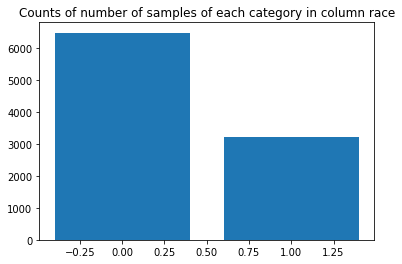

In [ ]:
grps = df_assessments_agg_filtered.groupby(A)
counts = {}
for k,v in grps:
    counts[k] = v.shape[0]
plt.bar(counts.keys(), counts.values())
plt.title(f"Counts of number of samples of each category in column {A}")
plt.show()

In [ ]:
class MyVanillaNN(SeldonianAlgorithm):
    """
    Implement a Seldonian Algorithm on a Neural network.
    """

    def __init__(self, X, y, test_size=0.4, g_hats=[], verbose=False, stratify=False, epochs=10,
                 model=None, random_seed=0):
        """
        Initialize a model with `g_hats` constraints. This class is an example of training a
        non-linear model like a neural network based on the Seldonian Approach.
        :param X: Input data, this also includes the safety set.
        :param y: targets for the data ``X``
        :param test_size: the fraction of ``X`` to be used for the safety test
        :param g_hats: a list of function callables that correspond to a constriant
        :param verbose: Set this to ``True`` to get some debug messages.
        :param stratify: set this to true if you want to do stratified sampling of safety set.
        :param epochs: number of epochs to run teh training of the model. Default: ``10``
        :param model: PyTorch model to use. Should be an instance of ``nn.Module``. Defaults to a 2 layer model with a binary output.
        """
        self.X = X
        self.y = y
        D = self.X.shape[1]
        H1 = 128
        self.device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Running on {self.device}")
        device = self.device
        self.constraint = g_hats
        self.verbose = verbose
        self.epochs = epochs
        # initialize the torch model using the Sequential API.
        if model is None:
            self.mod = nn.Sequential(
                nn.Linear(D, H1),
                nn.Linear(128, 64),
                nn.Linear(64, 32),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 2)
            ).to(device)
        else:
            self.mod = model.to(device)

        # Stratify the sampling method for safety and candidate set using the `stratify` param.
        if not stratify:
            self.X, self.X_s, self.y, self.y_s = train_test_split(
                self.X, self.y, test_size=test_size, random_state=random_seed
            )
            self.X = torch.as_tensor(self.X, dtype=torch.float, device=device)
            self.y = torch.as_tensor(self.y, dtype=torch.long, device=device)
            self.X_s = torch.as_tensor(self.X_s, dtype=torch.float, device=device)
            self.y_s = torch.as_tensor(self.y_s, dtype=torch.long, device=device)
        else:
            min_diff = np.inf
            count = 0
            self.X_t = self.X
            self.y_t = self.y
            while count < 30:
                self.X = self.X_t
                self.y = self.y_t
                self.X, self.X_s, self.y, self.y_s = train_test_split(
                    self.X, self.y, test_size=test_size,
                    random_state=count + 1
                )
                self.X = torch.as_tensor(self.X, dtype=torch.float, device=device)
                self.y = torch.as_tensor(self.y, dtype=torch.long, device=device)
                self.X_s = torch.as_tensor(self.X_s, dtype=torch.float, device=device)
                self.y_s = torch.as_tensor(self.y_s, dtype=torch.long, device=device)
                self.X_temp, self.X_s_temp, self.y_temp, self.y_s_temp = self.X, self.X_s, self.y, self.y_s
                if len(g_hats) > 0:
                    diff = abs(self._safetyTest(predict=True, ub=False) -
                               self._safetyTest(predict=False, ub=False))
                    if diff < min_diff:
                        self.X_temp, self.X_s_temp, self.y_temp, self.y_s_temp = self.X, self.X_s, self.y, self.y_s
                        min_diff = diff
                    count += 1
                else:
                    count += 30
            self.X, self.X_s, self.y, self.y_s = self.X_temp, self.X_s_temp, self.y_temp, self.y_s_temp
        self.loss_fn = nn.CrossEntropyLoss()
        # self.constraint = []
        if len(self.constraint) > 0:
            self.lagrange = torch.ones((len(self.constraint),), requires_grad=True, device=device)
        else:
            self.lagrange = None

        self.dataset = torch.utils.data.TensorDataset(self.X, self.y)
        self.loader = DataLoader(self.dataset, batch_size=300)
        if self.lagrange is not None:
            params = nn.ParameterList(self.mod.parameters())

            # optimizer used to train model parameters.
            self.optimizer = torch.optim.Adam(params, lr=6e-4)

            # optimizer used for adjusting the lagrange multipliers
            self.l_optimizer = torch.optim.Adam([self.lagrange], lr=6e-3)
        else:
            # if it is an unconstrained problem, just init the model optimizer.
            self.optimizer = torch.optim.Adam(self.mod.parameters(), lr=3e-3)
            self.l_optimizer = None
        pass

    def fit(self, **kwargs):
        running_loss = 0.0
        for epoch in range(self.epochs):
            for i, data in enumerate(self.loader, 0):
                x, y = data
                # print(x.shape, y.shape)
                self.optimizer.zero_grad()
                if self.l_optimizer is not None:
                    self.l_optimizer.zero_grad()
                out = self.mod(x)
                safety = self._safetyTest(predict=True)
                if self.lagrange is not None:
                    loss = self.loss_fn(out, y) + (self.lagrange ** 2).dot(
                        safety)
                else:
                    loss = self.loss_fn(out, y)
                loss.backward(retain_graph=True)
                # grad_check(self.mod.named_parameters())
                self.optimizer.step()

                if self.l_optimizer is not None:
                    self.l_optimizer.zero_grad()

                if self.lagrange is not None:
                    # loss_f = -1 * (self.loss_fn(self.mod(x), y) + (self.lagrange ** 2).dot(
                    #     self._safetyTest(predict=True)))
                    # loss_f.backward(retain_graph=True)
                    # # l_optimizer is a separate optimizer for the lagrangian.
                    # if self.l_optimizer is not None:
                    #     self.l_optimizer.step()
                    with torch.no_grad():
                        self.lagrange += 3e-3 * 2 * self.lagrange * safety
                    self.optimizer.zero_grad()
                running_loss += loss.item()

                if i % 10 == 9:  # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
        print("Training done.")
        pass

    def predict(self, X, pmf=False, as_numpy=False):
        # print(f"X is on device {X.get_device()}")
        if not torch.is_tensor(X):
            X = torch.as_tensor(X, dtype=torch.float, device=self.device)
        elif X.get_device() is not self.device:
            X.to(self.device)

        if not pmf:
            preds = torch.argmax(self.mod(X), dim=1)
        else:
            preds = nn.Softmax(dim=1)(self.mod(X))[:, 1]

        if as_numpy:
          return preds.detach().cpu().numpy()
      
        return preds

    def _safetyTest(self, predict=False, ub=True):
        with torch.no_grad():
            X_test = self.X if predict else self.X_s
            y_test = self.y if predict else self.y_s

        ghats = torch.empty(len(self.constraint), device=self.device)
        i = 0
        for g_hat in self.constraint:
            y_preds = self.predict(X_test, False)
            ghats[i] = g_hat['fn'](X_test, y_test, y_preds, g_hat['delta'], self.X_s.shape[0],
                                   predict=predict, ub=ub)
            # ghats[i] = ghat_val
            i += 1
        if predict:
            return ghats
        else:
            return np.clip(np.mean(ghats.detach().cpu().numpy()), a_min=0, a_max=None)

    def data(self):
        return self.X, self.y


def grad_check(named_params):
    avg = []
    for n, p in named_params:
        if p.requires_grad and ("bias" not in n):
            if p.grad is not None:
                avg.append(p.grad.abs().mean())
    print(f"Average gradient flow: {np.mean(avg)}")
    pass

# Constraint definition

In the Seldonian Approach, the safety constraints are defined as a tuple $(g_i, \delta_i) \forall i \in m$ , where there are $m$ safety constraints.  $g: \Theta \to \mathbb{R}$ is a function that quantifies the desirability of a solution and $\delta$ is the permissive probability of returning an undesirable/unsafe solution.  

Hence, if $f(\theta, D)$ is the original minimization optimization objective where $D$ is the data, then the new Seldonian objective function is: 
$$\arg_{\theta}\min f(\theta, D) \quad \quad \quad \text{s.t. } \Pr(g_i(\theta, D) \le 0 ) \ge 1- \delta_i \quad \forall i \in m  $$  

The trianing is a 3 step-process: 
- **Dataset split**: The input training data, $D$, is split into 2 sets - the candidate set, $D_{c}$, and the safety set, $D_{s}$.
- **Candidate selection** - This is the step executed when the `fit` method is called on the Seldonian Model. This method runs the optimization objective with the safety constraints using _only_ the data $D_c$. Since $D_s$ is not available at this step, we _predict_ the upper bound on $g(\theta, D_s)$, let's call it $\hat{g}(\theta, D_c)$ using concentration inequalities like $ttest$ or _Hoeffding's_ bounds. 
- **Safety test** - This step is used to run the trained parameters, $\theta_c$ from the candidate selection step and calculate $g(\theta_c, D_s)$.  

Here we set `g_hats` as a list of $g(\theta)$'s where each item is a dictionary with the `fn` key is assigned a function callable that calculates $g_i(\theta)$ and the $\delta_i$.  

In this case, we have only one constraint which is the recall constraint on the `Sex` category in the dataset. This constraint is also known as `EqualizedOdds` constraint from [Hardt et.al 2016](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf). The constraint is written as  

$$g(\theta) = |\Pr(f(\theta, X)=y |Y=y, A = Male) - \Pr(f(\theta, X)=y |Y=y, A = Female)| - 0.05 $$  

where `X` is the input features, `A` is the sensitive feature (`Sex` in this case) and `Y` is the target/prediction. The `0.05` is the maximum value that is permissible.  

Hence, this constraint upper bounds the absolute difference between the individual accuracy for each category of the sensitive attributes to `0.05`.  

We also split the entire dataset to a trainj and test set. Note that the test set here is _different_ from the safety set used within the Seldonian Algorithm.


In [ ]:
# true positive rate rate should be equal for X[A=1] or X[A=0]
def ghat_eq_odds_rate(A_idx, method='ttest', threshold=0.2):
    """
    Create a ``g_hat`` for the recall rate difference between :param A_idx subset versus
    the entire data.
    :param A_idx:
    :param method:
    :param threshold: Recall rate should not be greater than this value.
    :return: method that is to be sent to the Seldonian Algorithm and is used for calculating teh ``g_hat``
    """

    def eq_odds(X, y_true, y_pred, delta, n=None, predict=False, ub=True):
        recall_a = recall_rate(A_idx, 1)(X, y_true, y_pred)
        recall_b = recall_rate(A_idx, 0)(X, y_true, y_pred)
        tpr_a = tpr_rate(A_idx, 1)(X, y_true, y_pred)
        tpr_b = tpr_rate(A_idx, 0)(X, y_true, y_pred)

        abs_fn = abs
        # if torch.is_tensor(X):
        #     abs_fn = torch.abs

        if method == 'ttest':
            recall_diff = ttest_bounds(recall_b, delta, n, predict=predict) - ttest_bounds(recall_a, delta,
                                                                                 n,
                                                                                 predict=predict)
            tpr_diff = ttest_bounds(tpr_b, delta, n, predict=predict) - ttest_bounds(tpr_a, delta,
                                                                                 n,
                                                                                 predict=predict)
            if recall_diff.upper > tpr_diff.upper:
              bound = abs_fn(recall_diff)
            elif tpr_diff.upper > recall_diff.upper:
              bound = abs_fn(tpr_diff)
            else:
              bound = abs_fn(recall_diff)
        else:
            bound = abs_fn(
                hoeffdings_bounds(recall_b, delta, n, predict=predict) - hoeffdings_bounds(
                    recall_a, delta,
                    n,
                    predict=predict))
        if ub:
            return bound.upper - threshold
        else:
            return bound.value - threshold

    return eq_odds

In [ ]:
from sklearn.metrics import log_loss

def loss_rate(A_idx=None, A_val=None):
    def _ghat_loss(X, y_true, y_pred):
        loss = []
        if A_idx is not None and A_val is not None:
            mask = X[:, A_idx] == A_val
            y_true = y_true[mask]
            y_pred = y_pred[mask]

            for i in range(len(y_true)):
              loss.append(log_loss([y_true[i]], [y_pred[i]], labels=[0,1]))
        else:
            for i in range(len(y_true)):
              loss.append(log_loss([y_true[i]], [y_pred[i]], labels=[0,1]))
        return np.array(loss)

    return _ghat_loss

# true positive rate rate should be equal for X[A=1] or X[A=0]
def ghat_loss(A_idx, method='ttest', threshold=0.2):
    """
    Create a ``g_hat`` for the recall rate difference between :param A_idx subset versus
    the entire data.
    :param A_idx:
    :param method:
    :param threshold: Recall rate should not be greater than this value.
    :return: method that is to be sent to the Seldonian Algorithm and is used for calculating teh ``g_hat``
    """

    def loss(X, y_true, y_pred, delta, n=None, predict=False, ub=True):
        loss_a = loss_rate(A_idx, 1)(X, y_true, y_pred)
        loss_b = loss_rate(A_idx, 0)(X, y_true, y_pred)

        abs_fn = abs

        if method == 'ttest':
            bound = ttest_bounds(np.array([*loss_b, *loss_a]), delta, n, predict=predict)
        else:
            bound = abs_fn(
                hoeffdings_bounds(recall_b, delta, n, predict=predict) - hoeffdings_bounds(
                    recall_a, delta,
                    n,
                    predict=predict))
        if ub:
            return bound.upper - threshold
        else:
            return bound.value - threshold

    return loss

In [ ]:
X = df_assessments_agg_filtered[[*wanted_cols]]
Y = df_assessments_agg_filtered['pass_status_factor']

EO_THRESHOLD = 0.1
LOSS_THRESHOLD = 0.1

A_idx = list(X.columns).index(A)
X = X.to_numpy()
X_tr, X_te, y_tr,y_te = train_test_split(X, Y.to_numpy(), test_size=0.3, random_state=42)
g_hats = [
  {
    'fn': ghat_eq_odds_rate(A_idx, threshold=EO_THRESHOLD),
    'delta': 0.05
  },
  {
    'fn': ghat_loss(A_idx, threshold=LOSS_THRESHOLD),
    'delta': 0.05
  },
]

## Training the Seldonian Logistic Regression Model
The call to `model.fit()` run the candidate selection step and get the $\theta_c$ parameter. 

In [ ]:
model = LogisticRegressionSeldonianModel(X_tr, y_tr, g_hats=g_hats, test_size=0.3, stratify=True)
model.fit()

# Safety test
The call to `model._safetyTest()` runs the next step i.e.  the _safety test_ on the candidate model $\theta_c$.

In [ ]:
safe = model._safetyTest()
print(f"The trained model {'failed' if safe>0 else 'passed'} the safety test.")

The trained model failed the safety test.


# Seldonian Model metrics
Here, we report the Seldonian Model's accuracy and the violation i.e. the $g(\theta_c)$ on the test set `X_te`. We can see that the $g(\theta_c) < 0$. This means the candidate $\theta_c$ _passed_ the safety test.  

In [ ]:
print(f"Constrained model loss: {log_loss(y_te, model.predict(X_te))}")
print(f"Constrained model accuracy: {accuracy_score(y_te, model.predict(X_te))}")
print(f"Constrained model violation: {ghat_eq_odds_rate(A_idx, threshold=THRESHOLD)(X_te, y_te, model.predict(X_te), THRESHOLD, ub=False)} ")

Constrained model loss: 15.142188274381123
Constrained model accuracy: 0.5615966964900206
Constrained model violation: -0.04445128296236141 


# Unconstrained model metrics
Now, we compare this model to an unconstrained model trained on the same dataset using scikit learns `LogisticRegression` and the same metrics are then calculated on the test set `X_te`. 

In [ ]:
from sklearn.linear_model import LogisticRegression

uc_model = LogisticRegression(solver='liblinear', random_state=42).fit(X_tr, y_tr)

We can see that the unconstrained model _fails_ the safety test.

In [ ]:
g_theta_test = ghat_eq_odds_rate(A_idx, threshold=THRESHOLD)(X_te, y_te, uc_model.predict(X_te), THRESHOLD, ub=False)
print(f"Uncontrained model accuracy: {accuracy_score(y_te, uc_model.predict(X_te))}")
print(f"Unconstrained model value of g(\\theta): {g_theta_test}")
print(f"Hence, this model {'failed' if g_theta_test >0 else 'passed'} the safety test")

Uncontrained model accuracy: 0.7543014452856159
Unconstrained model value of g(\theta): 0.03554668663231898
Hence, this model failed the safety test
